In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [33]:
def init(laers_dims):
    
    #layers_dims : list of layers dimensions
    #first  dimension : input dimension
    #output : params: dict: contains W1, b1, ...
    
    params = {}
    for l in range(1, len(layers_dims)):
        params['W' + str(l)] = np.random.randn(layers_dims[l], layers_dims[l-1]) * np.sqrt(1. / layers_dims[l])
        params['b' + str(l)] = np.random.randn(layers_dims[l], 1) * np.sqrt(1. / layers_dims[l])
    
    return params


def relu(z):
    return np.maximum(0, z)

def relu_deriv(z):
    return z > 0

def softmax(z):
    z = z - np.max(z, axis = 0)
    
    y_hat = np.exp(z)/sum(np.exp(z))
    
    return y_hat

def softmax_deriv(z):
    d = softmax(z) - softmax(z)**2
    return d


def forward(X, params):
    
    # X : input : size(nb_features; nb samples)
    # params : dict : contains W1, b1, ...
    # output : activations: dict: A0, A1, Z1, ..., AL, ZL
    
    activations = {}
    
    L = len(params) // 2
    activations['A0'] = X
    
    for l in range(1, L):
        activations['Z' + str(l)] = np.dot(params['W' + str(l)], activations['A' + str(l-1)]) + params['b' + str(l)]
        activations['A' + str(l)] = relu(activations['Z' + str(l)])
        
    activations['Z' + str(L)] = np.dot(params['W' + str(L)], activations['A' + str(L-1)]) + params['b' + str(L)]
    activations['A' + str(L)] = softmax(activations['Z' + str(L)])
    
    return activations


def one_hot_encode(y):
    
    # function to one hot encode y : 
    # input : y : [1,2,3,...]
    # output : yoh : [0,1,0,0,0,0,0,0,0,0]
    
    nb_classes = int(y.max() + 1)
    m = len(y)
    y = y.astype(int)
    yoh = np.eye(m, nb_classes)[y].T
    
    return yoh   

def backward(params, activations, Y):
    
    Y = one_hot_encode(Y)
    L = len(params) // 2
    m = Y.shape[1]
    output = activations['A' + str(L)]
    
    grads = {}
    derivs = {}
    
    #output layer weights gradients
    derivs['Z' + str(L)] = output - Y
    grads['W' + str(L)] = (1/m) * np.dot(derivs['Z' + str(L)], activations['A' + str(L - 1)].T)
    grads['b' + str(L)] = (1/m) * np.sum(derivs['Z' + str(L)], axis = 1).reshape(-1,1)
    
    # for layer : 1 ..., L-1 apply formula
    for l in reversed(range(1, L)):
        derivs['Z' + str(l)] = np.dot(params['W' + str(l+1)].T, derivs['Z' + str(l+1)]) * relu_deriv(activations['Z' + str(l)])
        grads['W' + str(l)] = (1/m) * np.dot(derivs['Z' + str(l)], activations['A' + str(l-1)].T)
        grads['b' + str(l)] = (1/m) * np.sum(derivs['Z' + str(l)], axis = 1).reshape(-1,1)
    
    return grads
            

def update_weights(params, grads, llamda):
    
    # update weights and biases : from layer 1 ... L
    L = len(params) // 2
    for l in range(1, L+1):
        params['W' + str(l)] -= llamda * grads['W' + str(l)]
        params['b' + str(l)] -= llamda * grads['b' + str(l)]
    
    return params
    
def predict(AL):
    y_hat = np.argmax(AL, axis = 0)
    return y_hat

def accuracy(y_hat, y_true):
    acc = np.sum(y_hat == y_true)/ y_true.shape[0]
    return acc
    
def cross_entropy(AL, yoh):
    
    # clip the values of y : because of logarithm
    epsilon = 1e-12
    AL = np.clip(AL, epsilon, 1. - epsilon)
    
    entropy = - np.mean(np.sum(yoh * np.log(AL), axis = 0))
    
    return entropy
    
    
    
def optimizer(X, y, layers_dims, epochs = 500, llamda = 0.01):
    
    params = init_params(layers_dims)
    L = len(params) // 2
    yoh = one_hot_encode(y)
    
    accuracies = []
    losses = []
    
    # batch gradient descent
    for e in range(epochs):
        activations = forward(X, params)
        grads = backward(params, activations, y)
        params = update_weights(params, grads, llamda)
        
        AL = activations['A' + str(L)]
        preds = predict(AL)
        
        accuracies.append(accuracy(preds, y))
        losses.append(cross_entropy(AL, yoh))
        
        if e % 10 == 0:
            print('accuracy after ', e, 'epochs = ', accuracy(preds, y))
    
    return params , accuracies, losses
    
    

In [28]:
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split

# Fetch the MNIST dataset
mnist = fetch_openml('mnist_784')

# Split the dataset into train and test sets
X_train, X_test, y_train, y_test = train_test_split(
    mnist.data, mnist.target, test_size=0.2, random_state=42)

# Print the shapes of the train and test sets
print("Train set shape:", X_train.shape, y_train.shape)
print("Test set shape:", X_test.shape, y_test.shape)

Train set shape: (56000, 784) (56000,)
Test set shape: (14000, 784) (14000,)


In [29]:
#X_train, X_test = X_train.T, X_test.T 
#X_train, X_test = X_train/255., X_test/255. 
#y_train, y_test = y_train.astype('int32'), y_test.astype('int32')

In [34]:
layers_dims = [784, 256, 128, 64, 10]

In [35]:
params, accuracies, losses = optimizer(X_train, y_train, layers_dims)

accuracy after  0 epochs =  0.0965
accuracy after  10 epochs =  0.2092857142857143
accuracy after  20 epochs =  0.3344464285714286
accuracy after  30 epochs =  0.46382142857142855
accuracy after  40 epochs =  0.5488035714285714
accuracy after  50 epochs =  0.6051785714285715
accuracy after  60 epochs =  0.6504821428571429
accuracy after  70 epochs =  0.6861964285714286
accuracy after  80 epochs =  0.7160892857142858
accuracy after  90 epochs =  0.7384464285714286
accuracy after  100 epochs =  0.7574642857142857
accuracy after  110 epochs =  0.7726607142857143
accuracy after  120 epochs =  0.7848214285714286
accuracy after  130 epochs =  0.7950535714285715
accuracy after  140 epochs =  0.8034464285714286
accuracy after  150 epochs =  0.8114107142857143
accuracy after  160 epochs =  0.8180714285714286
accuracy after  170 epochs =  0.8238571428571428
accuracy after  180 epochs =  0.829375
accuracy after  190 epochs =  0.8336071428571429
accuracy after  200 epochs =  0.8377142857142857
acc

In [37]:
losses

[3.155948928085325,
 2.874417814801185,
 2.7215780212721574,
 2.6193166872240936,
 2.5424378404662327,
 2.4804233988321984,
 2.4282371684534216,
 2.3829512912739657,
 2.3426021945369615,
 2.30608177569324,
 2.272533748504601,
 2.2412641659897514,
 2.2118263892622956,
 2.1839078852381215,
 2.157269563082577,
 2.1316790594014954,
 2.1069506564759335,
 2.082994066255306,
 2.0596678861791378,
 2.036896878741851,
 2.0146172267220646,
 1.9927586360893708,
 1.971265373715759,
 1.9500990944067698,
 1.9292378987144057,
 1.9086708777374095,
 1.888359175948906,
 1.8682930284814858,
 1.8484551648745096,
 1.8288356281195612,
 1.809437432139985,
 1.790233973896467,
 1.7712236670705268,
 1.7524065414259087,
 1.7337856145048018,
 1.7153657269621554,
 1.6971389340628364,
 1.6791124242840716,
 1.6612638089315408,
 1.6436108134741736,
 1.6261794923396384,
 1.6089634756307507,
 1.5919565874467783,
 1.5751696376184843,
 1.5585943611102517,
 1.5422471534241886,
 1.5261258785005118,
 1.5102163115936318,
 1.4

Text(0.5, 0, 'X axis label')

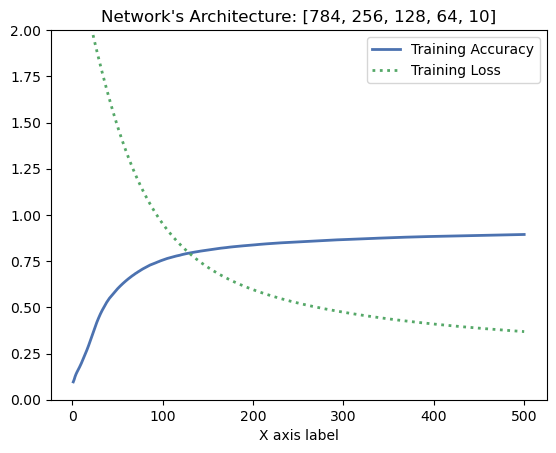

In [36]:
# plot training accuracy and loss
epochs = 500
plt.plot(range(1, epochs + 1), accuracies, '-', color=sns.color_palette('deep')[0], linewidth=2, label='Training Accuracy')
plt.plot(range(1, epochs + 1), losses, ':', color=sns.color_palette('deep')[2], linewidth=2, label='Training Loss')
plt.ylim(0, 2)
plt.title("Network's Architecture: {}".format(layers_dims))
plt.legend(loc="upper right")
plt.xlabel("X axis label")